# Zachary Renaud  
#### zlr10@pitt.edu

### Title: FBI Hate Crime Data Analysis

### Research Question:
How do hate crime trends vary across different states and categories over multiple years, and what patterns emerge in the demographics and locations of perpetrators that can inform targeted law enforcement intervention efforts?

### Abstract
For my final project, I’ve chosen to analyze hate crime data over multiple years. The primary goals of this project are:

- Investigating trends across different states and types of hate crimes.
- Identifying patterns in who is committing these crimes.
- Analyzing areas where concentrated efforts are needed to reduce hate crimes.

### Why is the research question interesting for me?
It addresses a pressing social issue and helps uncover patterns behind hate crimes, which have a real impact on communities.

### Why do I consider the project useful?
It provides actionable insights that can help prevent hate crimes by identifying areas and trends needing attention.

### Who would use your model or benefit from your model?
Law Enforcement: For better resource allocation.
Policy Makers: To create effective prevention strategies.
Community Organizations: To support affected communities with targeted initiatives.

This research is personally significant due to recent anti-Semitic incidents in Pittsburgh, which have led to shootings, stabbings, and physical abuse. I hope this project will shed light on cities or states that require additional resources and intervention to reduce hate crimes. The findings could especially benefit law enforcement by directing efforts to the areas with the most urgent need.

### Data Analysis Plan
The data analysis will focus on the following objectives:

- Aggregating hate crime totals by state and category.
- Summarizing total incidents and offenses across all data groups.
- Reporting instances where no data was reported, with particular attention to Pennsylvania.
- Generating graphs to visualize the trends and predict future hate crime occurrences.


In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats

In [44]:
df = pd.read_csv('by_state_hate_crimes.csv')

df.head()

,State,Year,State Total Population,Race/Ethnicity/Ancestry Incident,Religion Incident,Sexual Orientation Incident,Disability Incident,Gender Incident,Gender identity Incident,Total Incidents
0,Wyoming,2023,284793.0,10.0,7.0,2.0,0.0,0.0,2.0,21
1,Wyoming,2022,199468.0,11.0,3.0,8.0,0.0,2.0,1.0,25
2,Wyoming,2021,150371.0,11.0,2.0,4.0,1.0,1.0,0.0,19
3,Wisconsin,2023,2056763.0,73.0,25.0,26.0,8.0,4.0,12.0,148
4,Wisconsin,2022,2089219.0,72.0,29.0,28.0,6.0,9.0,8.0,152


### Data Cleaning "by_state_hate_crimes"
* The data set above is actually a data set that I have created.
* The actual data comes from the FBI Hate Crimes Hate Crime Statistics Annual Reports between the years 2023-2021
* This data set merges together the hate crime reports by type, for every state, by year, and reports the given population each agency reported
* Original Data Sets found here: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads
* They're arent any missing values in this data set
* Although we will have to work with the set because of unusual numbers:


       State  Year  State Total Population  Race/Ethnicity/Ancestry Incident  \
125  Florida  2021                     NaN                               NaN   

     Religion Incident  Sexual Orientation Incident  Disability Incident  \
125                NaN                          NaN                  NaN   

     Gender Incident  Gender identity Incident  Total Incidents  
125              NaN                       NaN                0  


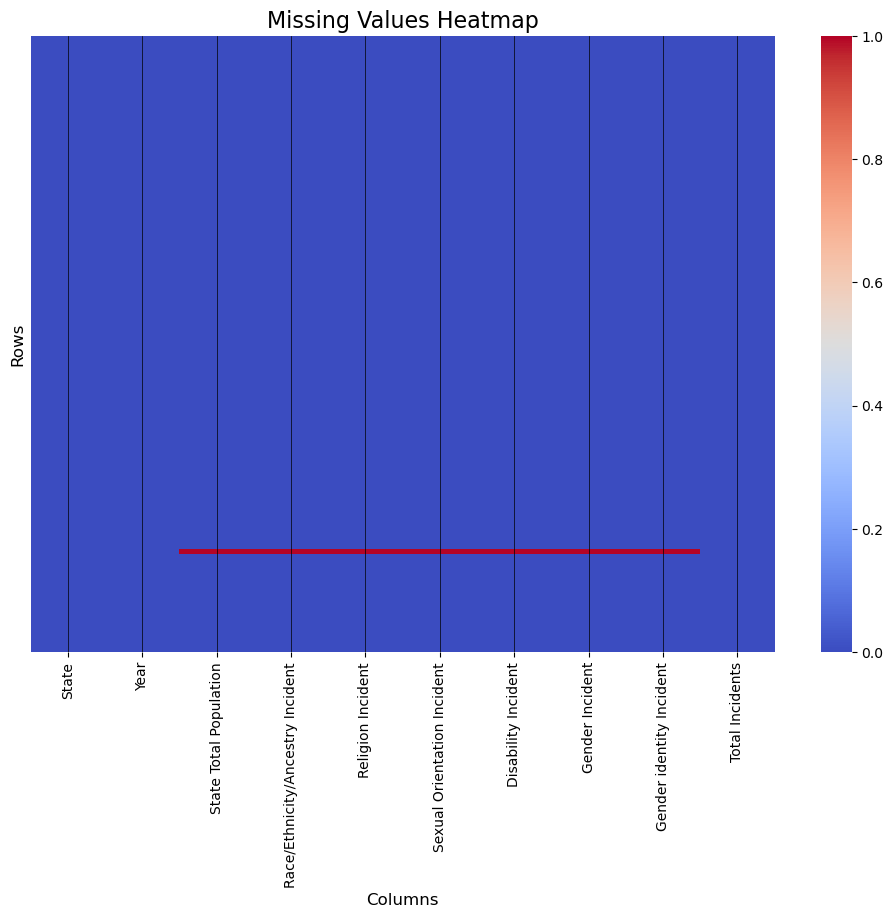

In [46]:
# Cleaning Up the Data

#Look for null or NaN values
if df.isnull().any().any():  
    print(df[pd.isnull(df).any(axis=1)])  
else:
    print("No NaN values in the DataFrame.")

plt.figure(figsize=(12, 8))
sns.heatmap(df.isna(), cbar=True, cmap='coolwarm', yticklabels=False, xticklabels=True)
plt.grid(True, which='both', axis='both', color='black', linestyle='-', linewidth=0.5)
plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)
plt.show()

df_cleaned = df.copy()  
df_cleaned = df_cleaned.dropna()

### Understanding Missing Values in the Heatmap

#### Visualizing the Data

In the heatmap of missing values, each cell represents a data point, and the color indicates whether the value is missing (NaN) or present. Missing values are typically marked in a distinct color, such as **yellow** in our case, to make them stand out clearly.

#### Why is the Bar Important?

- **The bar** indicates that the row has **missing data (NaN or Null)** for certain columns, which are crucial for analysis.
- When we see a row almost entirely marked it means that key values are missing, compromising the reliability of that data point.
- In this case, the missing data should likely be removed from the dataset because it introduces uncertainty and may lead to incorrect conclusions or modeling issues.

#### Conclusion

By removing rows with missing values, we ensure that our dataset remains clean and reliable, improving the accuracy of any subsequent analysis or modeling tasks. It's critical to handle such missing values correctly to avoid skewing results.


In [48]:
def remove_outliers_by_state(df, threshold=0.75):
    state_mean = df.groupby('State')['State Total Population'].transform('mean')
    df['Population Difference'] = (df['State Total Population'] - state_mean).abs()
    
    to_remove = df[df['Population Difference'] > threshold * state_mean]
    print("Removed Values:")
    print(to_remove)
    
    df_filtered = df[df['Population Difference'] <= threshold * state_mean]
    df_filtered = df_filtered.drop(columns=['Population Difference'])
    return df_filtered

df_cleaned = remove_outliers_by_state(df_cleaned)

Removed Values:
          State  Year  State Total Population  \
56     New York  2021               1429871.0   
92     Maryland  2021                 74316.0   
137  California  2021               2376930.0   
146      Alaska  2021                 29580.0   

     Race/Ethnicity/Ancestry Incident  Religion Incident  \
56                               32.0               21.0   
92                               56.0               14.0   
137                              49.0                6.0   
146                               5.0                0.0   

     Sexual Orientation Incident  Disability Incident  Gender Incident  \
56                          15.0                  0.0              2.0   
92                          12.0                  2.0              1.0   
137                         16.0                  0.0              0.0   
146                          4.0                  0.0              2.0   

     Gender identity Incident  Total Incidents  Population Differe

### Why Remove These Values?

#### Let's look at New York's population values over three years:

| **State**   | **Year** | **State Total Population** |
|-------------|----------|----------------------------|
| **New York** | 2021     | 1,429,871                  |
| **New York** | 2022     | 10,570,429                 |
| **New York** | 2023     | 11,061,692                 |

* The population in **2021** is drastically lower compared to 2022 and 2023, which are much higher and more consistent.
* This extreme drop in 2021 indicates an outlier, potentially due to lingering covid effects.
* By removing values like New York 2021, we ensure our model is based on more consistent and realistic population trends, improving its accuracy in future predictions.

---

## Visualization of the Distributions:


<Figure size 1500x1000 with 0 Axes>

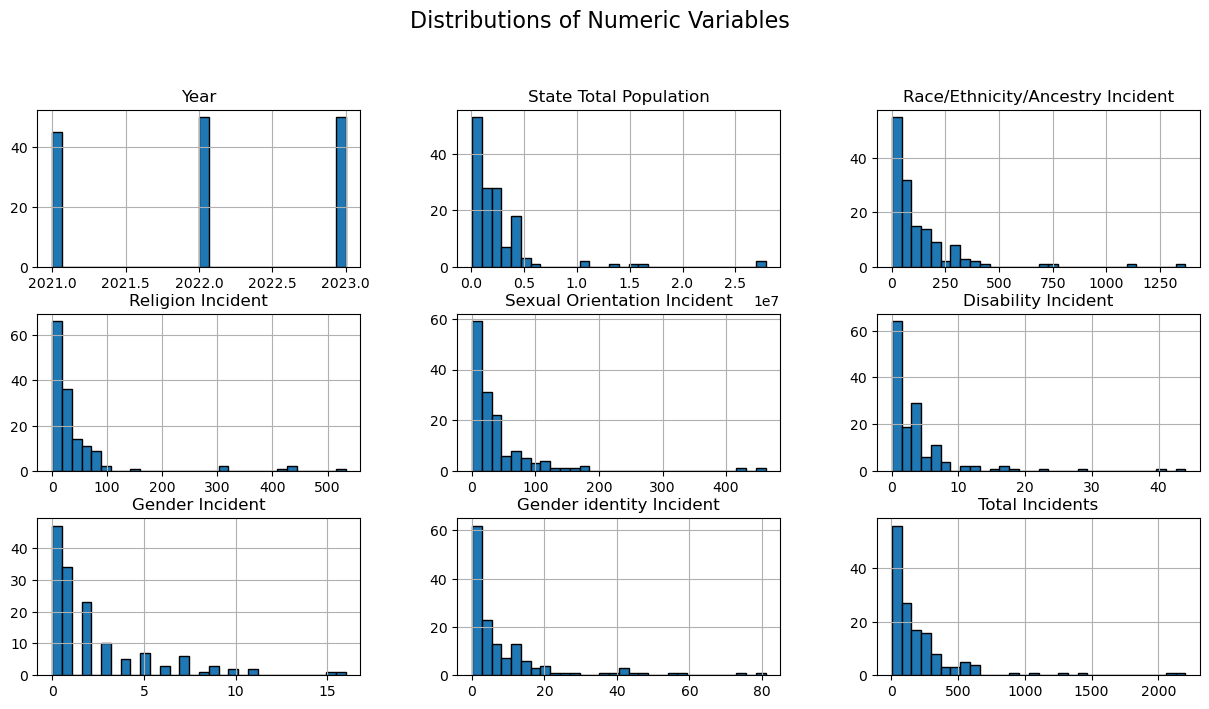

In [50]:
numeric_columns = df_cleaned.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))
numeric_columns.hist(bins=30, figsize=(15, 10), layout=(4, 3), edgecolor='black')

plt.suptitle('Distributions of Numeric Variables', fontsize=16)

plt.show()


### Visualizing the Data Distributions

Now that we’ve seen the distributions visualized, let’s take a closer look.  
We’ll analyze the **skewness** of the data to determine the best approach:  
- *Transform* the data  
- *Scale* the data  


In [51]:
from scipy.stats import skew

def safe_skew(x):
    try:
        return skew(x.dropna())
    except:
        return 0  

numeric_columns = df_cleaned.select_dtypes(include=['number']).columns

skew_by_state = df_cleaned.groupby('State')[numeric_columns].apply(lambda x: x.apply(safe_skew))

print(skew_by_state)


C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\855147238.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(x.dropna())


                Year  State Total Population  \
State                                          
Alabama          0.0                0.418554   
Alaska           0.0                0.000000   
Arizona          0.0               -0.496513   
Arkansas         0.0               -0.698062   
California       0.0                0.000000   
Colorado         0.0               -0.581133   
Connecticut      0.0                0.703738   
Delaware         0.0               -0.409747   
Florida          0.0                0.000000   
Georgia          0.0                0.033203   
Hawaii           0.0                0.529132   
Idaho            0.0                0.405687   
Illinois         0.0               -0.707046   
Indiana          0.0               -0.441296   
Iowa             0.0               -0.055759   
Kansas           0.0               -0.697938   
Kentucky         0.0               -0.665696   
Louisiana        0.0               -0.509302   
Maine            0.0                0.57

### Analyzing Skewness

After identifying the skewness of the data, the next step is to visualize it.  
This will help us better understand the distribution and decide on any necessary adjustments.  


C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\4163346209.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')


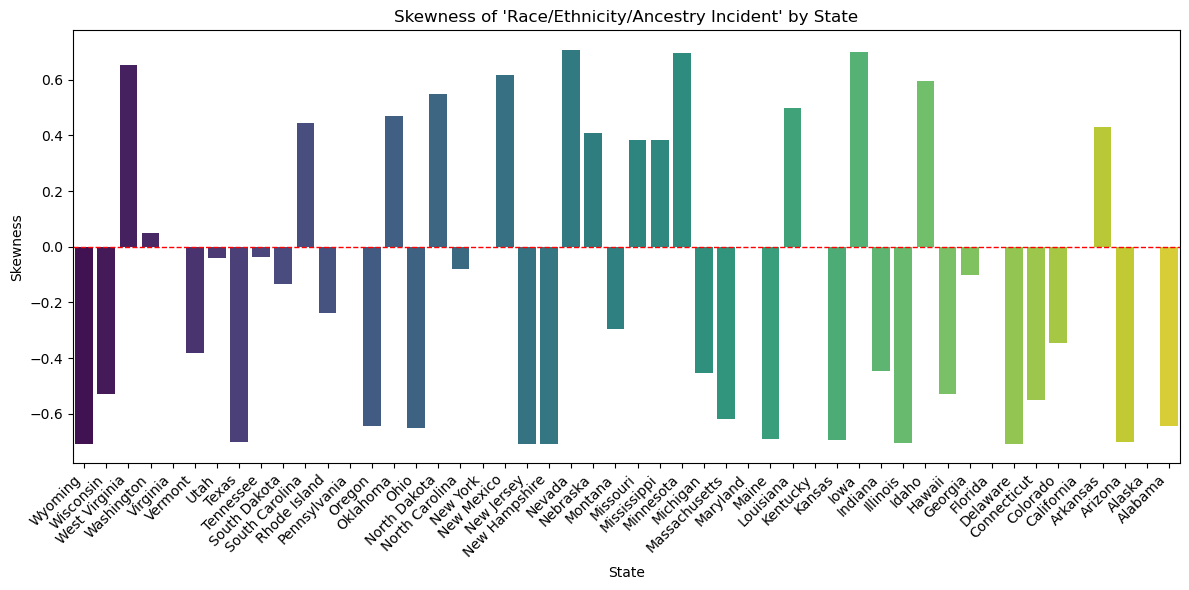

C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\4163346209.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')


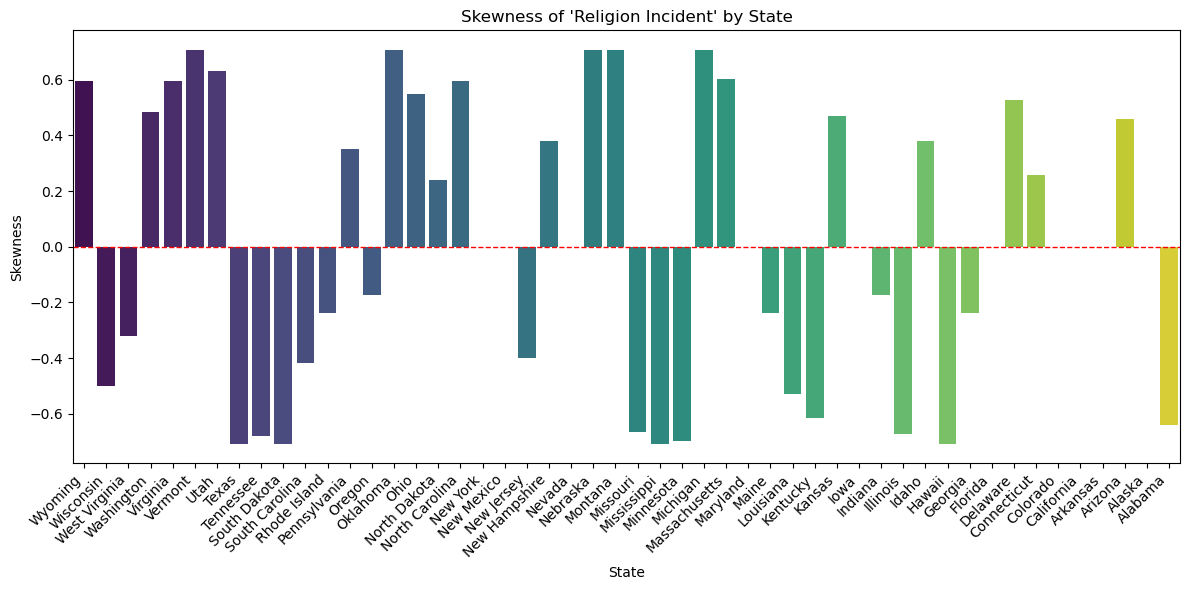

C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\4163346209.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')


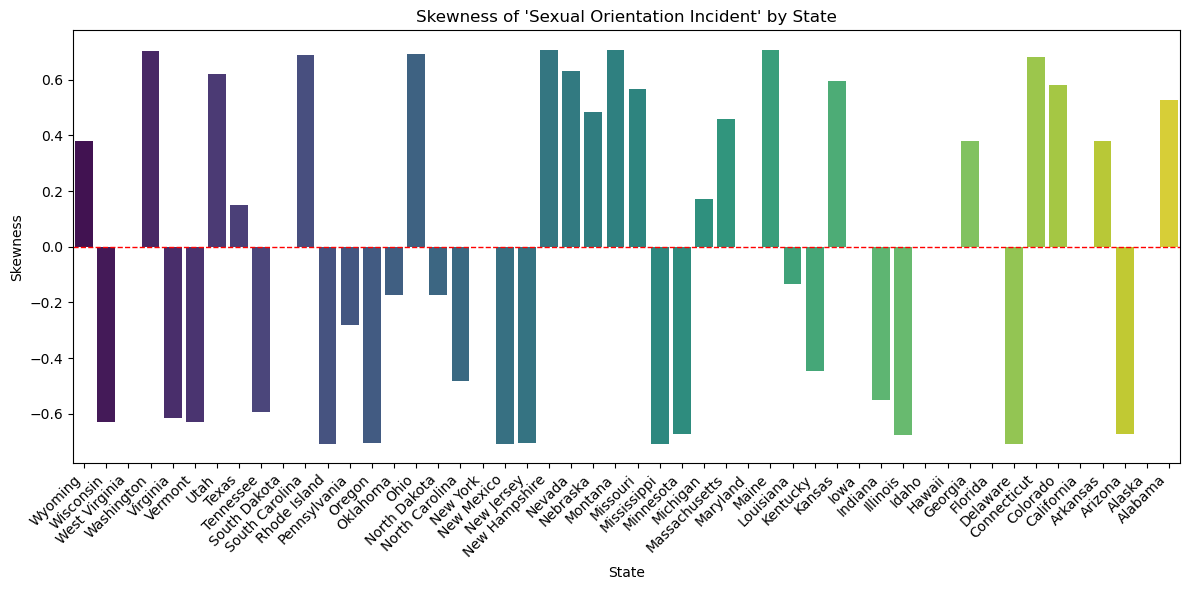

C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\4163346209.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')


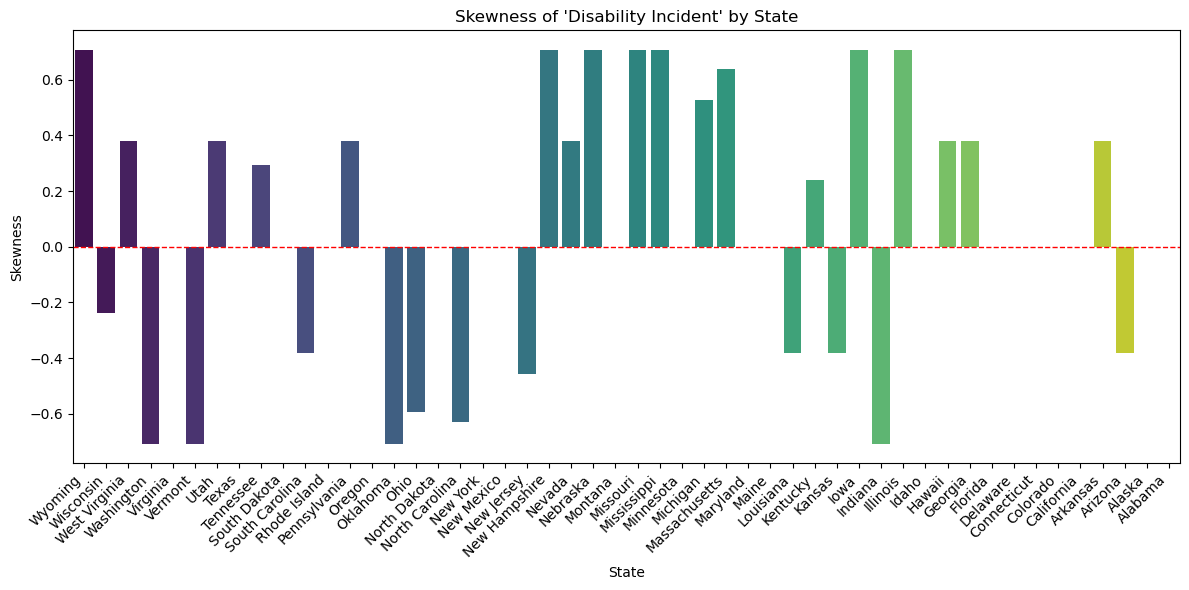

C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\4163346209.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')


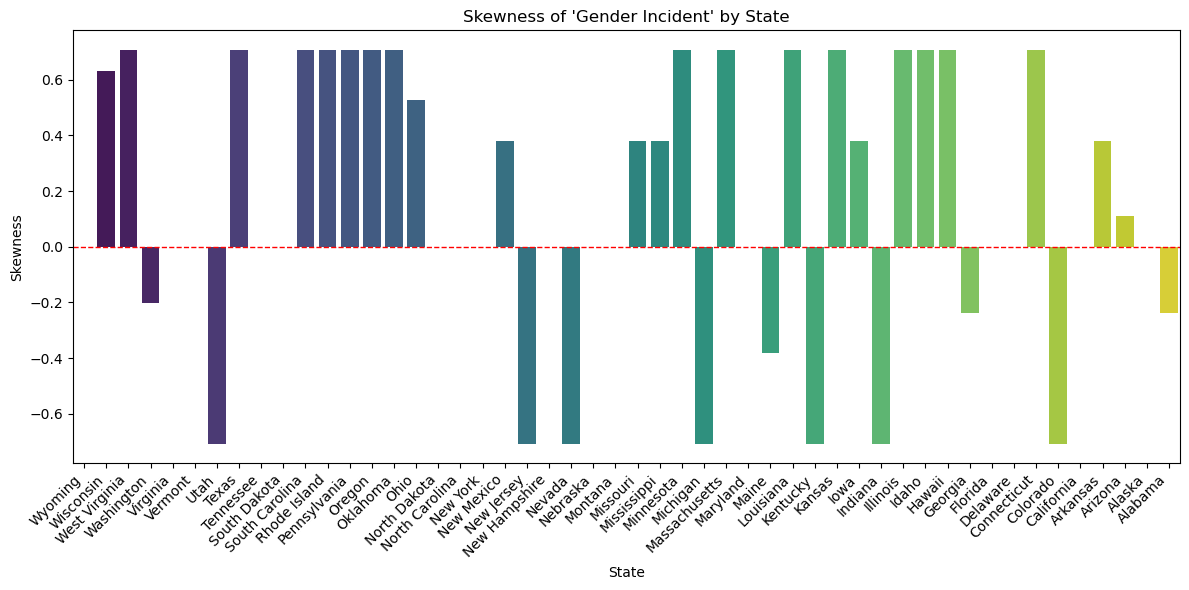

C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\4163346209.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')


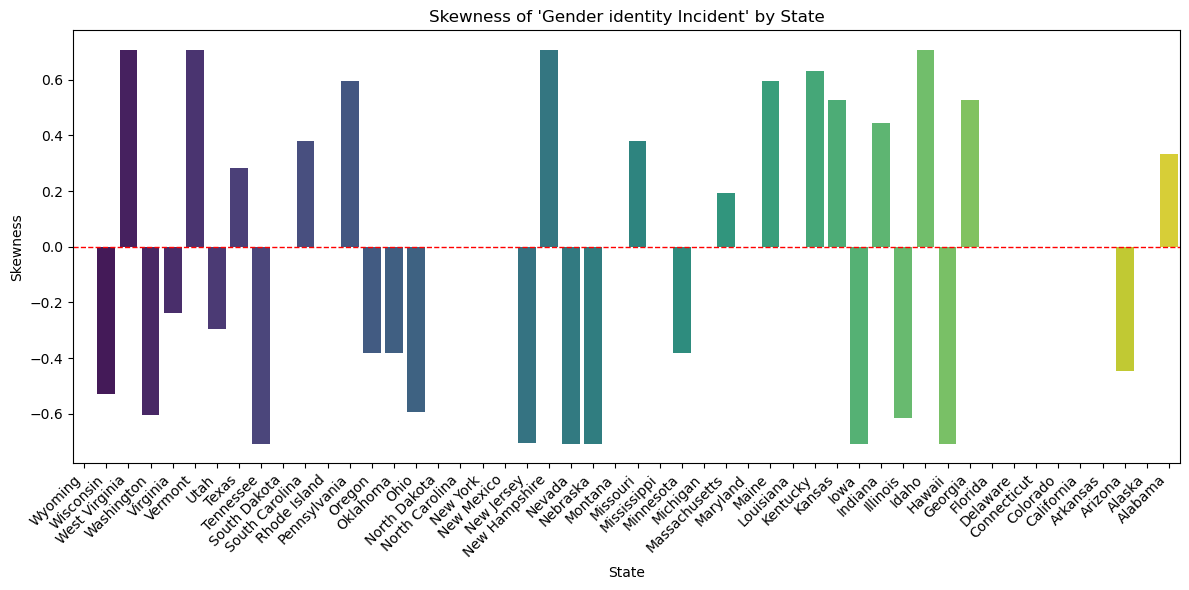

C:\Users\zacha\AppData\Local\Temp\ipykernel_25524\4163346209.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')


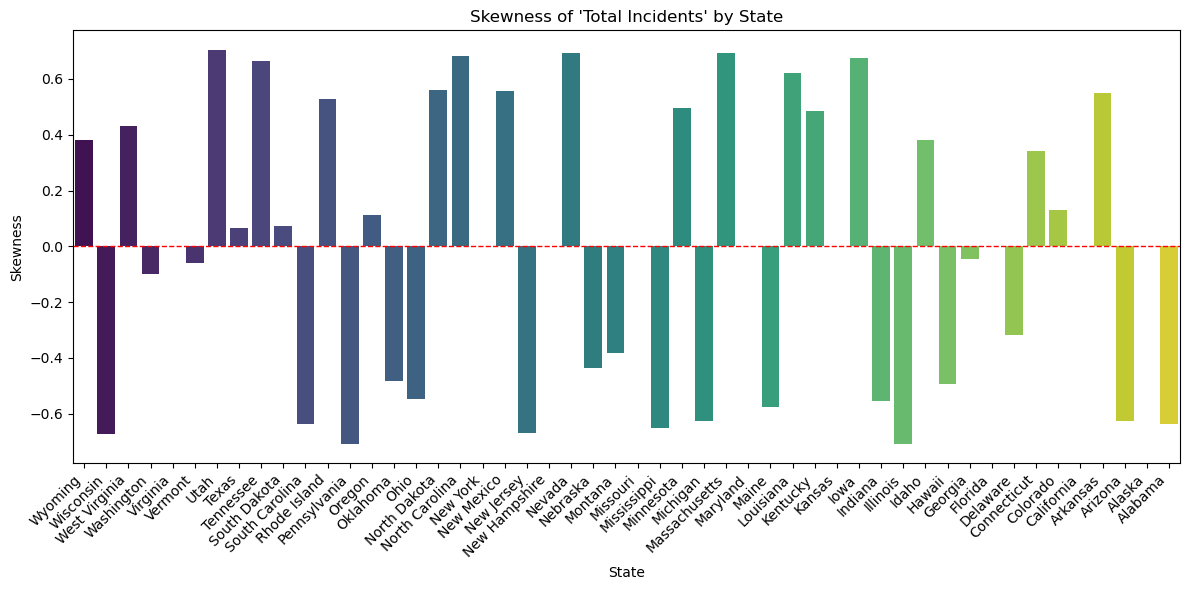

In [52]:
def visualize_skewness_by_state(df, columns):
    if 'State' not in df.columns:
        print("The DataFrame must have a 'State' column.")
        return
    
    states = df['State'].unique()
    skewness_data = []

    for state in states:
        state_data = df[df['State'] == state]
        if state_data.empty:
            continue

        for column in columns:
            if column not in state_data.columns:
                print(f"Column {column} not found in state {state}. Skipping.")
                continue
            
            column_data = state_data[column].dropna()
            if column_data.nunique() > 1:
                column_skewness = skew(column_data)
            else:
                column_skewness = np.nan  

            skewness_data.append({
                'State': state,
                'Column': column,
                'Skewness': column_skewness
            })

    skewness_df = pd.DataFrame(skewness_data)

    for column in columns:
        plt.figure(figsize=(12, 6))
        subset = skewness_df[skewness_df['Column'] == column]
        sns.barplot(data=subset, x='State', y='Skewness', palette='viridis')
        plt.axhline(0, color='red', linestyle='--', linewidth=1)  
        plt.title(f"Skewness of '{column}' by State")
        plt.xlabel('State')
        plt.ylabel('Skewness')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


columns_to_analyze = ['Race/Ethnicity/Ancestry Incident', 'Religion Incident', 'Sexual Orientation Incident',
                      'Disability Incident', 'Gender Incident', 'Gender identity Incident', 'Total Incidents']
visualize_skewness_by_state(df_cleaned, columns_to_analyze)

# **It appears we may not need to transform the data by state:**
After evaluating the dataset, no columns apeared to be skwewed enough to require a transformation
Howver, we should check to see, just to be sure:

----


In [54]:
print(df.columns)

Index(['State', 'Year', 'State Total Population',
       'Race/Ethnicity/Ancestry Incident', 'Religion Incident',
       'Sexual Orientation Incident', 'Disability Incident', 'Gender Incident',
       'Gender identity Incident', 'Total Incidents'],
      dtype='object')


In [55]:
def best_transformations_for_columns_grouped_by_state(df, columns):
    if 'State' not in df.columns:
        print("The DataFrame does not have a 'State' column.")
        return

    states = df['State'].unique()
    print(f"States found in the DataFrame: {states}")

    results_data = []

    for state in states:
        state_data = df[df['State'] == state]
        if state_data.empty:
            continue

        for column in columns:
            if column not in state_data.columns:
                continue

            try:
                if state_data[column].nunique() <= 1:
                    continue

                # Calculate original skewness
                original_skewness = stats.skew(state_data[column])
                if -2 <= original_skewness <= 2:
                    results_data.append({
                        'State': state,
                        'Column': column,
                        'Best Transformation': 'Original',
                        'Skewness': f"{original_skewness:.3f}"
                    })
                    continue

                # Perform transformations if skewness exceeds ±2
                transformations = {
                    'Log': np.log1p(state_data[column]) if (state_data[column] >= 0).all() else None,
                    'Square Root': np.sqrt(state_data[column]) if (state_data[column] >= 0).all() else None,
                    'Box-Cox': stats.boxcox(state_data[column] + 1)[0] if (state_data[column] > 0).all() else None,
                    'Yeo-Johnson': PowerTransformer(method='yeo-johnson').fit_transform(state_data[[column]]).flatten(),
                    'PowerTransformer': PowerTransformer().fit_transform(state_data[[column]]).flatten()
                }

                skewness_results = {}
                for name, data in transformations.items():
                    if data is not None:
                        if isinstance(data, np.ndarray):
                            data = pd.Series(data)
                        skewness_results[name] = stats.skew(data) if data.nunique() > 1 else None

                best_trans = min(skewness_results, key=lambda x: abs(skewness_results[x]) if skewness_results[x] is not None else np.inf)
                best_skewness = skewness_results[best_trans]

                results_data.append({
                    'State': state,
                    'Column': column,
                    'Best Transformation': best_trans,
                    'Skewness': f"{best_skewness:.3f}" if best_skewness is not None else "N/A"
                })

            except Exception as e:
                print(f"Error processing column {column} in state {state}: {e}")

    if not results_data:
        print("No results generated. Verify your data and transformations.")
        return

    results_df = pd.DataFrame(results_data)
    print("\nBest Transformations by State and Column:")
    print(results_df.pivot(index="State", columns="Column", values="Best Transformation"))


columns_to_test = [
    'Race/Ethnicity/Ancestry Incident', 
    'Religion Incident', 
    'Sexual Orientation Incident', 
    'Disability Incident', 
    'Gender Incident', 
    'Gender identity Incident', 
    'Total Incidents'
]

best_transformations_for_columns_grouped_by_state(df_cleaned, columns_to_test)

States found in the DataFrame: ['Wyoming' 'Wisconsin' 'West Virginia' 'Washington' 'Virginia' 'Vermont'
 'Utah' 'Texas' 'Tennessee' 'South Dakota' 'South Carolina' 'Rhode Island'
 'Pennsylvania' 'Oregon' 'Oklahoma' 'Ohio' 'North Dakota' 'North Carolina'
 'New York' 'New Mexico' 'New Jersey' 'New Hampshire' 'Nevada' 'Nebraska'
 'Montana' 'Missouri' 'Mississippi' 'Minnesota' 'Michigan' 'Massachusetts'
 'Maryland' 'Maine' 'Louisiana' 'Kentucky' 'Kansas' 'Iowa' 'Indiana'
 'Illinois' 'Idaho' 'Hawaii' 'Georgia' 'Florida' 'Delaware' 'Connecticut'
 'Colorado' 'California' 'Arkansas' 'Arizona' 'Alaska' 'Alabama']

Best Transformations by State and Column:
Column         Disability Incident Gender Incident Gender identity Incident  \
State                                                                         
Alabama                   Original        Original                 Original   
Alaska                    Original             NaN                 Original   
Arizona                   Ori

# **Why We Don’t Need to Transform the Data**

After evaluating the dataset, I found that none of the columns had skewness values exceeding ±2, indicating that the data distributions are already balanced.

---

## **1. Evaluating Distribution**
I assessed the skewness of each column for all states in the dataset:
- **Threshold**: Data is considered moderately skewed if skewness is between ±1 and ±2. Severe skewness is indicated by values beyond ±2.
- **Observation**: None of the columns had skewness values outside ±2, or even above ±1, meaning the distributions are sufficiently symmetrical for modeling without requiring transformations.

---

## **2. Visualizing Distributions**
Visualizations of a bar chart with the skewness showed the following:
- If the data exhibits normality or near-normality.
- Whether extreme outliers are skewing the distribution.

Since the skewness fell within acceptable ranges, visualizations were not essential but did offer a nice aid.

---

## **3. Addressing (Transforming) Skewed Distributions**
Transformations for this dataset:
- Columns were tested for transformations only if their skewness exceeded ±2.
- Results showed that all columns returned either `'Original'` (indicating no transformation needed) or `NaN` (indicating constant or untransformable data).

Thus, I did not apply any transformations.

---

## **4. Explanations / Justification for Approach**

### **Why No Transformations?**
- **Skewness Check**: All columns were within the acceptable skewness range of ±2, meaning their distributions are not significantly skewed.
- **Preserving Interpretability**: Avoiding unnecessary transformations ensures that the data remains interpretable and easy to relate back to real-world measurements.



----
‎        

### Scaling the Data

Now, let’s explore scaling the data—  
we’ll do this both **visually** and by **checking the statistical details**,  
to ensure our transformations are well-suited for further analysis.



Descriptive statistics by State:
                Year                                                      \
               count    mean       std     min      25%     50%      75%   
State                                                                      
Alabama          3.0  2022.0  1.000000  2021.0  2021.50  2022.0  2022.50   
Alaska           2.0  2022.5  0.707107  2022.0  2022.25  2022.5  2022.75   
Arizona          3.0  2022.0  1.000000  2021.0  2021.50  2022.0  2022.50   
Arkansas         3.0  2022.0  1.000000  2021.0  2021.50  2022.0  2022.50   
California       2.0  2022.5  0.707107  2022.0  2022.25  2022.5  2022.75   
Colorado         3.0  2022.0  1.000000  2021.0  2021.50  2022.0  2022.50   
Connecticut      3.0  2022.0  1.000000  2021.0  2021.50  2022.0  2022.50   
Delaware         3.0  2022.0  1.000000  2021.0  2021.50  2022.0  2022.50   
Florida          2.0  2022.5  0.707107  2022.0  2022.25  2022.5  2022.75   
Georgia          3.0  2022.0  1.000000  2021.0  2021.5

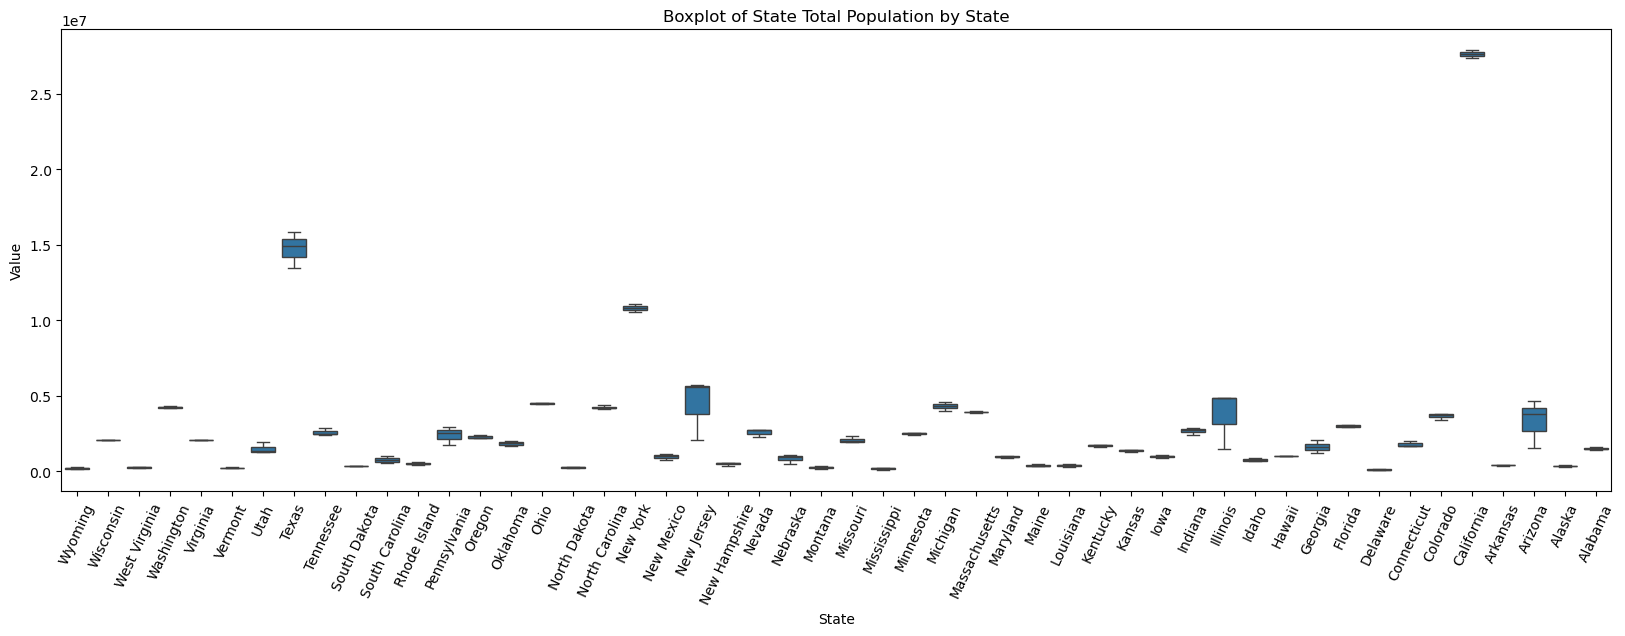

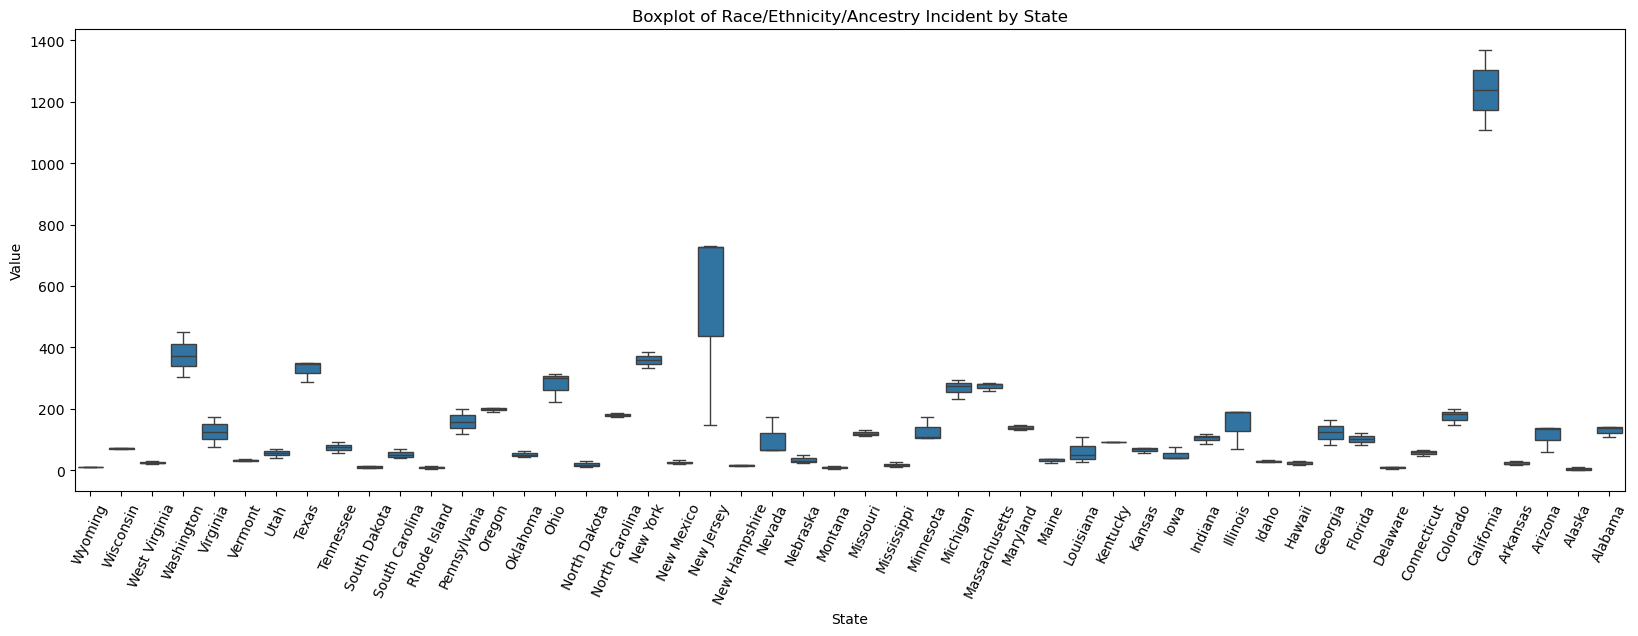

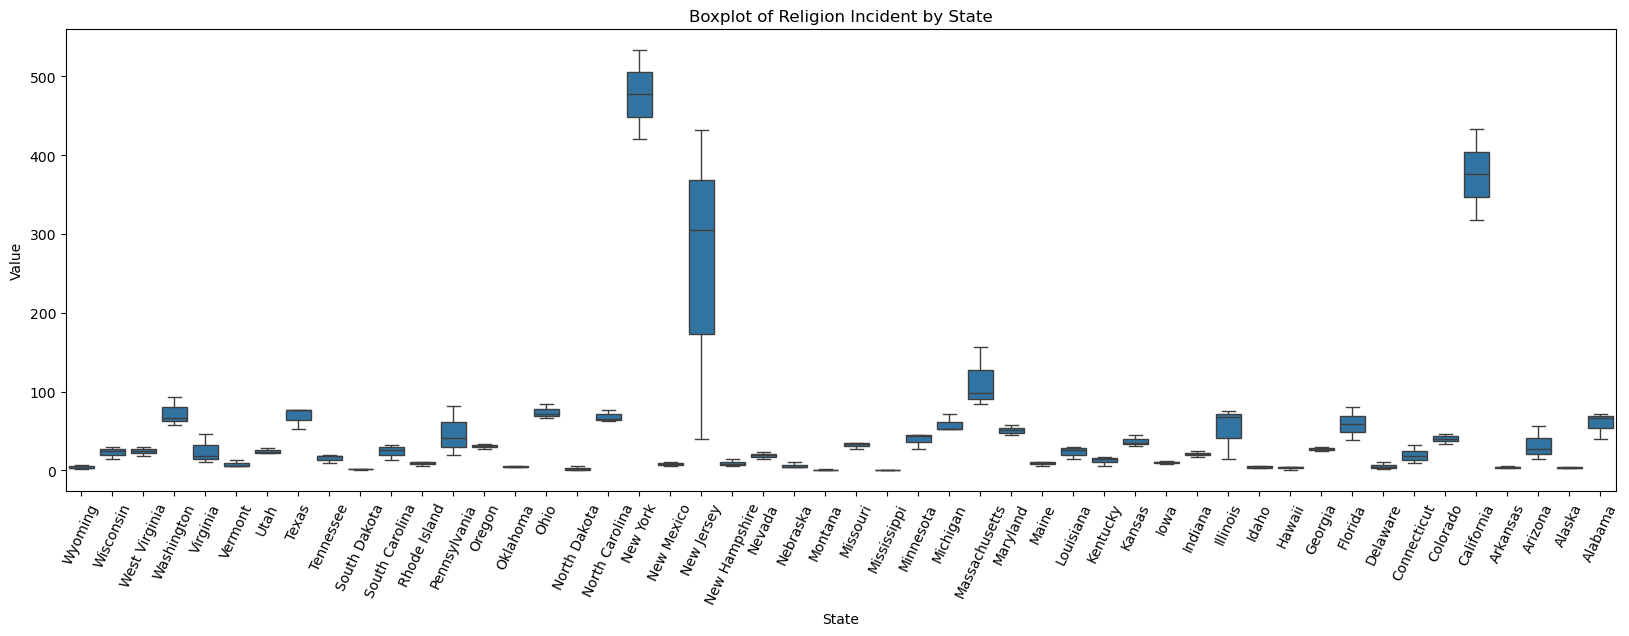

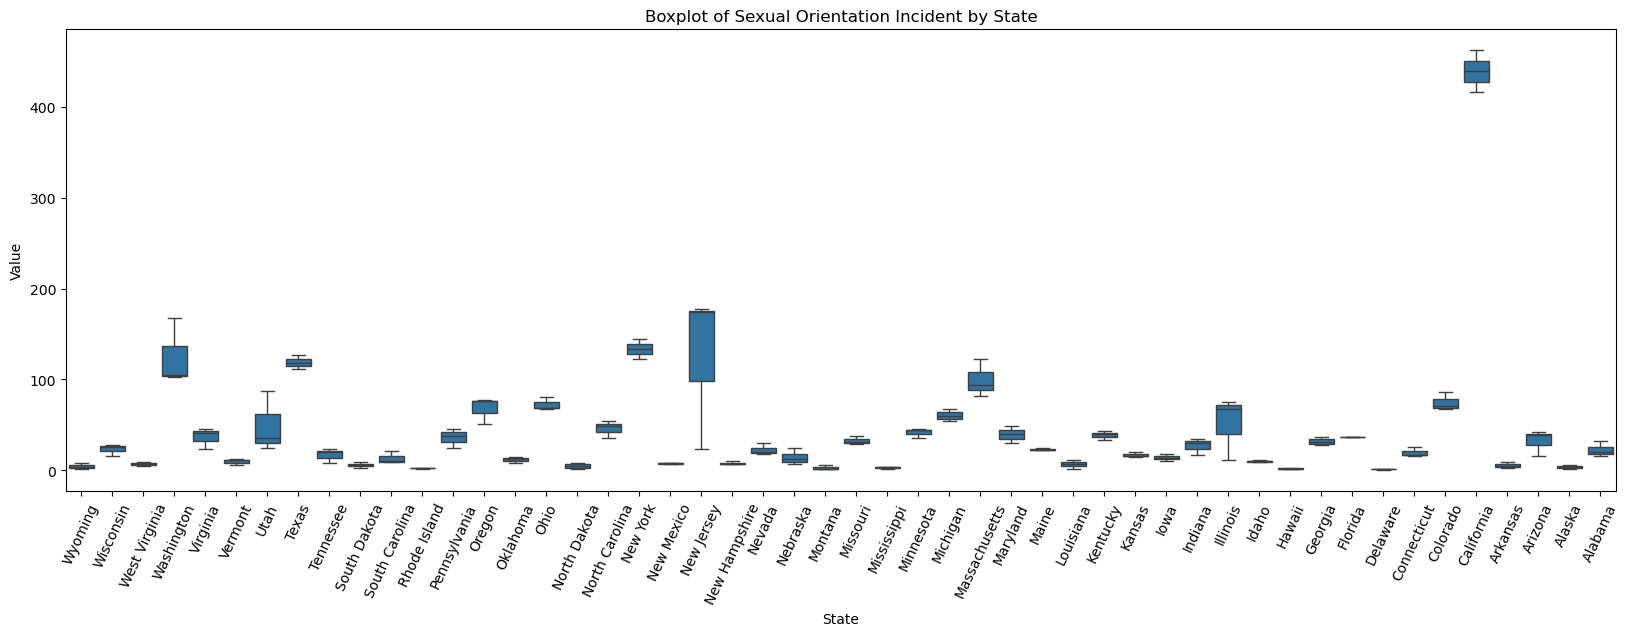

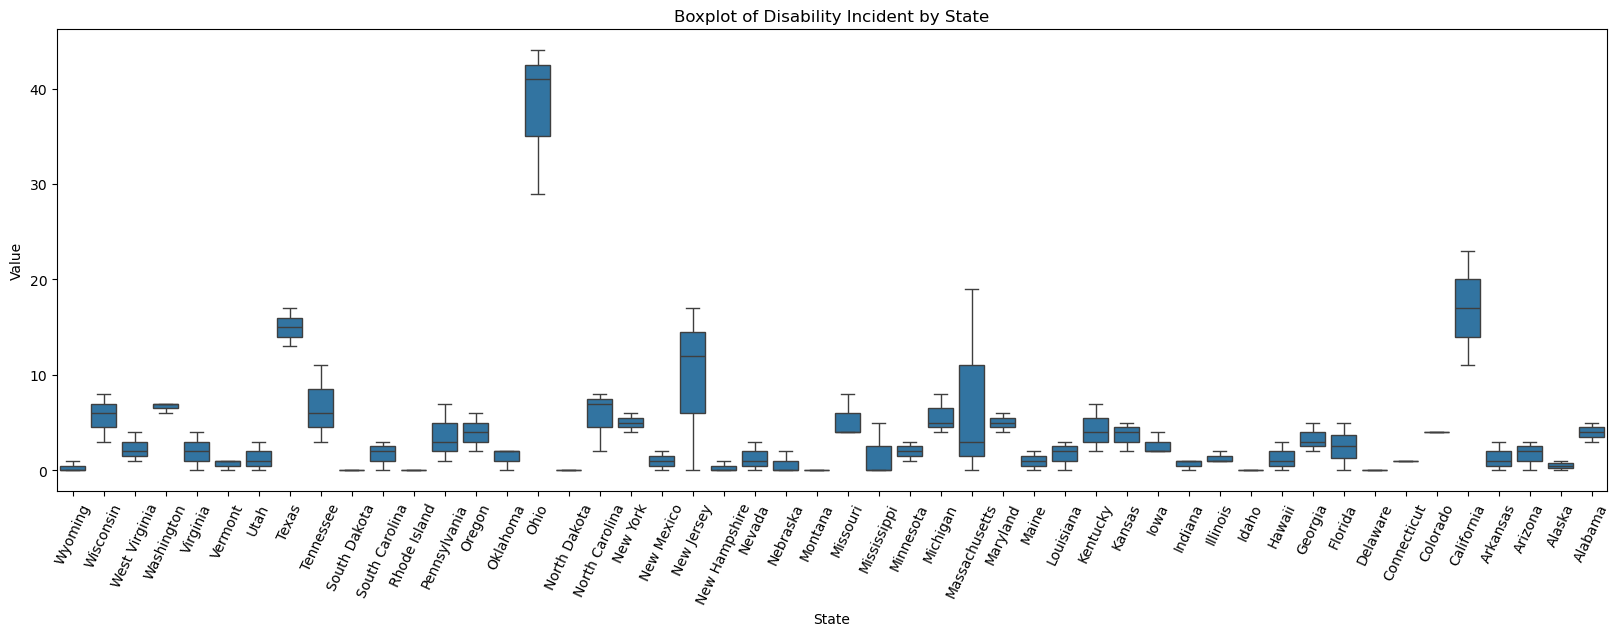

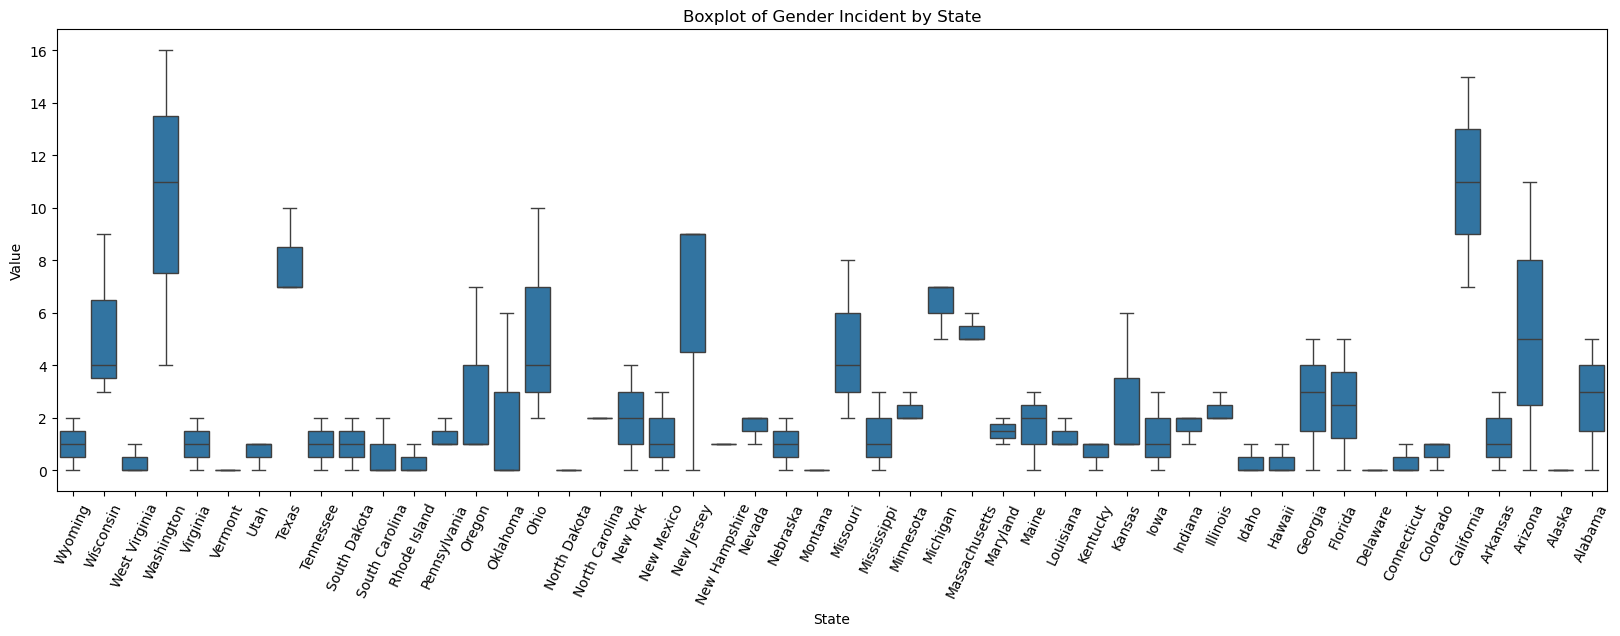

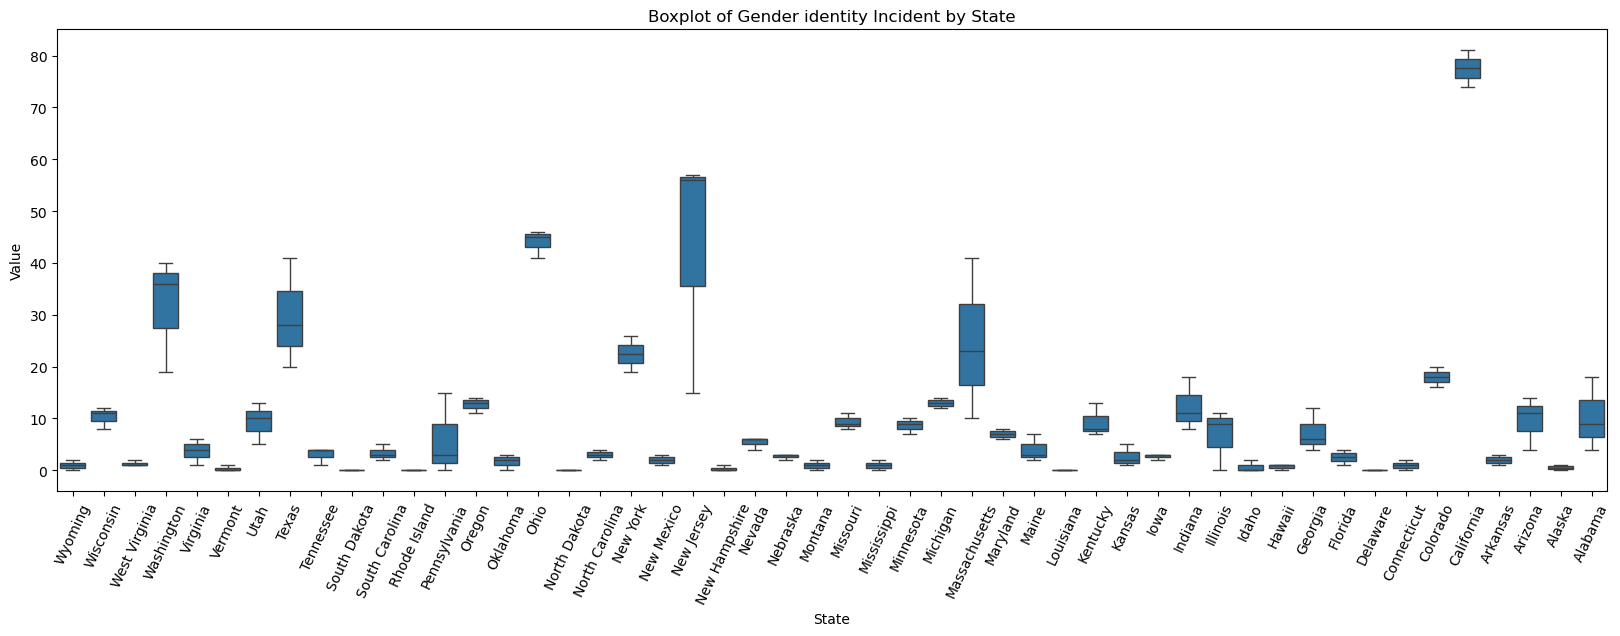

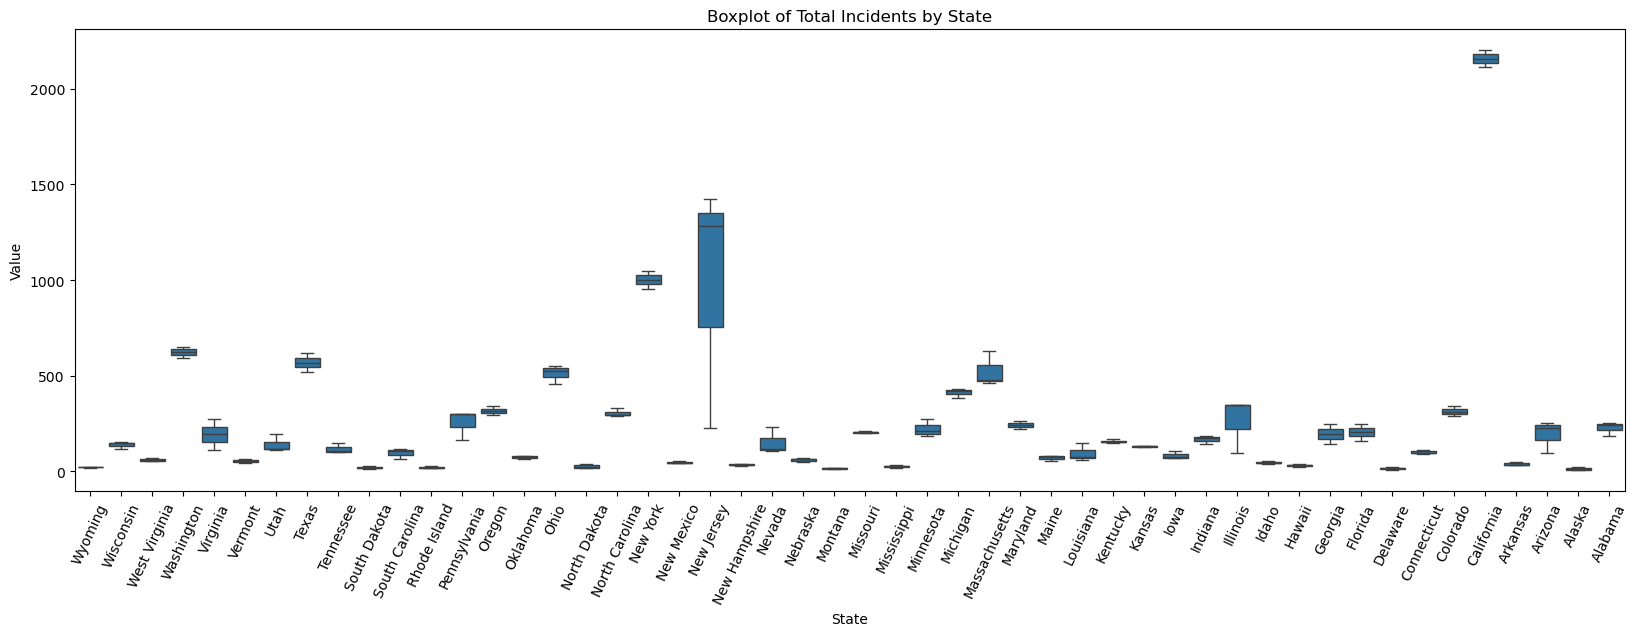

In [58]:
state_groups = df_cleaned.groupby('State')

print("\nDescriptive statistics by State:")
print(state_groups.describe())

print("\nSkewness by State:")
print(state_groups[['State Total Population',
       'Race/Ethnicity/Ancestry Incident', 'Religion Incident',
       'Sexual Orientation Incident', 'Disability Incident', 'Gender Incident',
       'Gender identity Incident', 'Total Incidents']].apply(lambda x: x.skew()))


columns_to_plot = [
    'State Total Population',
       'Race/Ethnicity/Ancestry Incident', 'Religion Incident',
       'Sexual Orientation Incident', 'Disability Incident', 'Gender Incident',
       'Gender identity Incident', 'Total Incidents'
]

for column in columns_to_plot:
    plt.figure(figsize=(20, 6))
    sns.boxplot(x='State', y=column, data=df_cleaned)
    plt.title(f'Boxplot of {column} by State')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.xticks(rotation=65)
    plt.show()

# Why Scaling Is Not Necessary for the Analysis

## 1. **State-Specific Analysis**
The analysis focuses on comparing hate crime data **grouped by state**, where the **absolute values** matter. 

- Scaling would obscure the **real-world magnitude** of values, which is critical for understanding the significance of differences (e.g., California vs. Alaska).
- For example, knowing that **California reported 2,157 incidents** versus **Alaska’s 13 incidents** provides meaningful insights that scaled values (e.g., 1.23 vs. -1.12) would obscure.

---

## 2. **Preserving Interpretability**
By not scaling, the raw numbers remain directly interpretable:

- For example, "California’s population is 27 million, and Alaska’s is 340,000" conveys more context than scaled values.
- Unscaled data ensures your stakeholders (e.g., law enforcement or policymakers) can relate findings to real-world scenarios.

---

## 3. **Distribution of Data**
From the descriptive statistics found:

- The ranges of many columns are **relatively small and manageable** (e.g., incident totals for Alabama range from 187 to 255).
- While some columns (e.g., **State Total Population**) have larger ranges, these reflect **real-world differences** that are part of the analysis.

---

## 4. **Tree-Based Algorithms (If Used)**
Random Forest models will be used later:

- These algorithms split data based on thresholds and **do not require scaled inputs**.

---

## 5. **Box Plots and Visualizations**
Box plots compare **relative distributions** and focus on percentiles, showing the need of not scaling.

---

By keeping the data unscaled, my interpretability remains and my findings will remain grounded in reality.


# **Perdicting Total State and Nation Numbers:**



---


R² score on training data: 0.9539
Mean Squared Error (MSE) on training data: 4815.42
Mean Absolute Error (MAE) on training data: 38.80


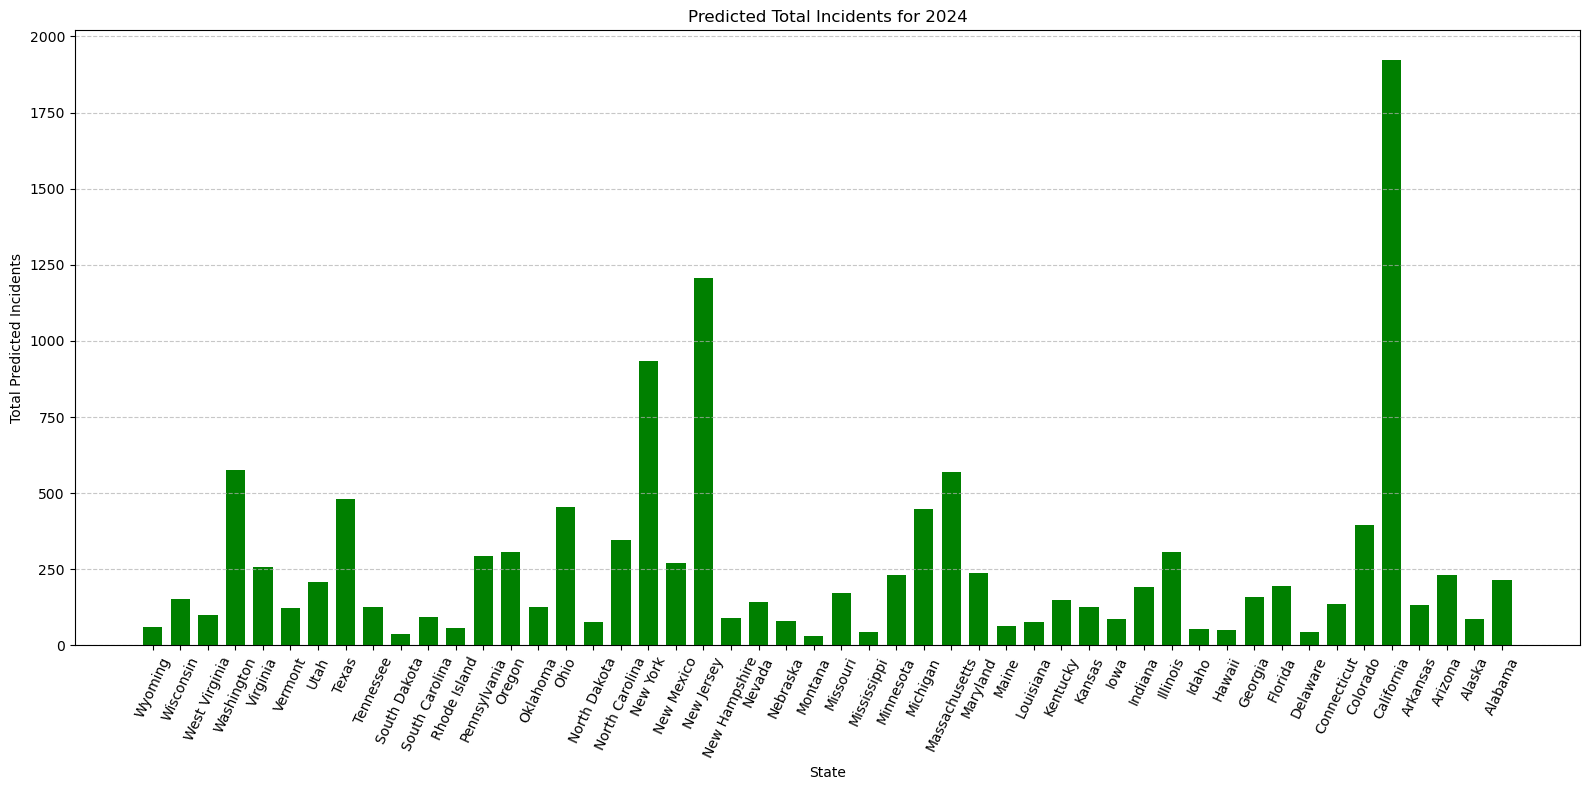


**Estimated Total Number of Hate Crimes for 2024**: 12954

Predicted Total Incidents by State for 2024
    State_Name  Predicted_Total
    California             1924
    New Jersey             1206
      New York              933
    Washington              575
 Massachusetts              570
         Texas              480
          Ohio              453
      Michigan              447
      Colorado              396
North Carolina              345
      Illinois              307
        Oregon              307
  Pennsylvania              295
    New Mexico              270
      Virginia              257
      Maryland              236
     Minnesota              232
       Arizona              232
       Alabama              213
          Utah              209
       Florida              196
       Indiana              191
      Missouri              171
       Georgia              160
     Wisconsin              151
      Kentucky              150
        Nevada              144


In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

agg_data = df_cleaned.groupby(['State', 'Year'])[['Total Incidents']].sum().reset_index()

label_encoder = LabelEncoder()
agg_data['State'] = label_encoder.fit_transform(agg_data['State'])

X = agg_data[['State', 'Year']]
y = agg_data['Total Incidents']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"\nR² score on training data: {r2:.4f}")
print(f"Mean Squared Error (MSE) on training data: {mse:.2f}")
print(f"Mean Absolute Error (MAE) on training data: {mae:.2f}")

states_encoded = label_encoder.transform(df['State'].unique())
year_2024_data = pd.DataFrame({'State': states_encoded, 'Year': [2024]*len(states_encoded)})

year_2024_data['Predicted_Total'] = model.predict(year_2024_data)
year_2024_data['Predicted_Total'] = year_2024_data['Predicted_Total'].round().astype(int)

year_2024_data['State_Name'] = label_encoder.inverse_transform(year_2024_data['State'])

plt.figure(figsize=(16, 8))
plt.bar(year_2024_data['State_Name'], year_2024_data['Predicted_Total'], color='g', width=0.7)

plt.title(f'Predicted Total Incidents for 2024')
plt.xlabel('State')
plt.ylabel('Total Predicted Incidents')
plt.xticks(rotation=65)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

estimated_total_crimes_2024 = year_2024_data['Predicted_Total'].sum()
print(f"\n**Estimated Total Number of Hate Crimes for 2024**: {estimated_total_crimes_2024}")

predicted_table = year_2024_data[['State_Name', 'Predicted_Total']].sort_values(by='Predicted_Total', ascending=False)
print("\nPredicted Total Incidents by State for 2024")
print(predicted_table.to_string(index=False))


### Model Evaluation Metrics

1. **R² Score: 0.9539**
- The R² score of **0.9539** indicates that approximately **95.39%** of the variability in the target variable (*Total Incidents*) is captured by the model.
- This suggests that the model fits the training data very well and can explain a large proportion of the observed data variability.

2. **Mean Squared Error (MSE): 4815.42**
- The MSE of **4815.42** measures the average squared difference between the predicted and actual values.
- Since the R² is high, this MSE indicates that our model's predictions closely align with actual incident counts.
- For large incident counts, this MSE value is relatively small and within acceptable limits.

3. **Mean Absolute Error (MAE): 38.80**
- The MAE of **38.80** indicates that, on average, our model's predictions deviate from the actual incident numbers by about **±39 incidents**.
- This demonstrates a good level of predictive accuracy and shows that the deviations are minor compared to the scale of incident counts.

---

### Feature Selection
#### 1. **Input Features (X):**
   - **`State`**: Encoded using `LabelEncoder` to convert categorical state names into numerical values.
   - **`Year`**: A numerical feature capturing temporal trends in hate crimes.

#### 2. **Target Variable (y):**
   - **`Total Incidents`**: The total number of hate crime incidents aggregated by state and year.

This selection ensures the model focuses on both geographical and temporal patterns critical to understanding hate crime trends.
The model after this will feature more features as it perdicts more data

---

### Conclusion

- The high **R² score** suggests a strong fit on the training data.
- The **MSE** and **MAE** values indicate good predictive performance with only small deviations from actual incident counts.
- Our model is performing well and captures the patterns in the data effectively.

----
‎        

# **Perdicting Incidents by Column:**



---

In [65]:
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

incident_columns = [
    'Total Incidents',
    'Race/Ethnicity/Ancestry Incident',
    'Religion Incident',
    'Sexual Orientation Incident',
    'Disability Incident',
    'Gender Incident',
    'Gender identity Incident'
]

agg_data = df_cleaned.groupby(['State', 'Year'])[incident_columns].sum().reset_index()

label_encoder = LabelEncoder()
agg_data['State'] = label_encoder.fit_transform(agg_data['State'])

states_encoded = label_encoder.transform(df_cleaned['State'].unique())
year_2024_data = pd.DataFrame({'State': states_encoded, 'Year': [2024] * len(states_encoded)})

for column in incident_columns:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train = agg_data[['State', 'Year']]
    y_train = agg_data[column]
    
    model.fit(X_train, y_train)

    year_2024_data[f'Predicted_{column}'] = model.predict(year_2024_data[['State', 'Year']]).round().astype(int)

    y_pred = model.predict(X_train)
    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)

    print(f"\nMetrics for predicting {column}:")
    print(f"R² score: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

year_2024_data['State_Name'] = label_encoder.inverse_transform(year_2024_data['State'])

predicted_2024_data_for_table = year_2024_data[['State_Name'] + [f'Predicted_{column}' for column in incident_columns]]
table_data = predicted_2024_data_for_table.values.tolist()

headers = ['State'] + incident_columns

print("\nPredicted 2024 Incident Data for Each State")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


Metrics for predicting Total Incidents:
R² score: 0.9539
Mean Squared Error (MSE): 4815.42
Mean Absolute Error (MAE): 38.80

Metrics for predicting Race/Ethnicity/Ancestry Incident:
R² score: 0.9535
Mean Squared Error (MSE): 1487.28
Mean Absolute Error (MAE): 20.61

Metrics for predicting Religion Incident:
R² score: 0.9245
Mean Squared Error (MSE): 502.73
Mean Absolute Error (MAE): 11.65

Metrics for predicting Sexual Orientation Incident:
R² score: 0.9611
Mean Squared Error (MSE): 140.16
Mean Absolute Error (MAE): 7.30

Metrics for predicting Disability Incident:
R² score: 0.9478
Mean Squared Error (MSE): 2.15
Mean Absolute Error (MAE): 1.02

Metrics for predicting Gender Incident:
R² score: 0.8627
Mean Squared Error (MSE): 1.27
Mean Absolute Error (MAE): 0.77

Metrics for predicting Gender identity Incident:
R² score: 0.9431
Mean Squared Error (MSE): 11.07
Mean Absolute Error (MAE): 2.24

Predicted 2024 Incident Data for Each State
+----------------+-------------------+------------

## Model Analysis for Incident Prediction Performance

I evaluated the performance of separate RandomForestRegressor models for each incident column. Here's a breakdown of the performance metrics for each type of incident:

1. **Total Incidents**
- **R² Score**: 0.9539  
  This high R² value indicates that the model explains about 95.39% of the variance in the Total Incidents data.
- **Mean Squared Error (MSE)**: 4815.42  
  The MSE of 4815.42 reflects the average squared differences between actual and predicted incident counts.
- **Mean Absolute Error (MAE)**: 38.80  
  The MAE of 38.80 shows the average absolute difference in incident counts between actual and predicted values.

2. **Race/Ethnicity/Ancestry Incident**
- **R² Score**: 0.9535  
  An R² value of 95.35% suggests that the model fits the data very well.
- **Mean Squared Error (MSE)**: 1487.28  
- **Mean Absolute Error (MAE)**: 20.61  

3. **Religion Incident**
- **R² Score**: 0.9245  
  This R² value indicates that about 92.45% of the variance in religion incidents is captured by the model.
- **Mean Squared Error (MSE)**: 502.73  
- **Mean Absolute Error (MAE)**: 11.65  

4. **Sexual Orientation Incident**
- **R² Score**: 0.9611  
  A very high R² of 96.11% demonstrates excellent model performance.
- **Mean Squared Error (MSE)**: 140.16  
- **Mean Absolute Error (MAE)**: 7.30  

5. **Disability Incident**
- **R² Score**: 0.9478  
- **Mean Squared Error (MSE)**: 2.15  
- **Mean Absolute Error (MAE)**: 1.02  

6. **Gender Incident**
- **R² Score**: 0.8627  
  The R² value of 86.27% indicates a relatively decent fit.
- **Mean Squared Error (MSE)**: 1.27  
- **Mean Absolute Error (MAE)**: 0.77  

7. **Gender Identity Incident**
- **R² Score**: 0.9431  
- **Mean Squared Error (MSE)**: 11.07  
- **Mean Absolute Error (MAE)**: 2.24

### Feature Selection in Multi-Category Incident Prediction

### Feature Selection

#### 1. **Input Features (X):**
   - **`State`**: Encoded using `LabelEncoder` to convert categorical state names into numerical representations. This captures the geographical aspect of hate crime trends.
   - **`Year`**: A numerical feature to incorporate temporal trends.

These two features (`State` and `Year`) are used to predict hate crime incidents across multiple categories, ensuring the model considers spatial and temporal dependencies.

#### 2. **Target Variables (y):**
   - **Incident Categories**:
     - `Total Incidents`
     - `Race/Ethnicity/Ancestry Incident`
     - `Religion Incident`
     - `Sexual Orientation Incident`
     - `Disability Incident`
     - `Gender Incident`
     - `Gender Identity Incident`
   - Each column represents a distinct aspect of hate crime, providing a more detailed breakdown of predicted trends.

---

### Feature Selection Justification
1. **Geographical Patterns (State):**
   - Different states may exhibit distinct hate crime patterns due to cultural, political, or demographic factors.

2. **Temporal Trends (Year):**
   - Historical data shows the evolution of hate crime incidents over time, essential for accurate future predictions.

3. **Category-Specific Predictions:**
   - By modeling each incident category individually, the approach ensures that trends unique to each type of hate crime are captured effectively.

---

### Predictive Modeling Process
1. **Model Selection:**
   - **Random Forest Regressor**: A robust model capable of handling non-linear relationships and feature interactions.

2. **Training and Prediction:**
   - The model is trained on `State` and `Year` for each incident category (`y_train`).
   - Predictions for 2024 are generated for all states.

3. **Evaluation Metrics:**
   - **R² Score**: Measures variance explained by the model.
   - **Mean Squared Error (MSE)**: Quantifies prediction errors.
   - **Mean Absolute Error (MAE)**: Assesses the magnitude of prediction errors.

---

### Conclusion
The models show strong performance across most incident categories, with **R² values typically above 0.9**, indicating good predictive power. The **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** values vary but remain low for most incident columns, ensuring accurate predictions.

This analysis demonstrates that our separate models for each incident type are well-suited for accurately predicting incidents across different states and years.


# Zero Hate Crime Report Data Cleaning

After analyzing the total hate crimes by nation, state, and column,  
I will now focus on the cases where **no hate crimes were reported**.  
This step is crucial to ensure data completeness and accuracy.


In [68]:
df_2023 = pd.read_csv('zero_data_pa_2023.csv')
df_2022 = pd.read_csv('zero_data_pa_2022.csv')
df_2021 = pd.read_csv('zero_data_pa_2021.csv')

df_2023.head()
df_2022.head()
df_2021.head()

,Agency Location,1st\n quarter,2nd\n quarter,3rd\n quarter,4th\n quarter,Population
0,Abbottstown,NaN,0.0,0.0,NaN,"1,036"
1,Alburtis,NaN,NaN,0.0,0.0,"2,578"
2,Aldan,NaN,0.0,0.0,0.0,"4,186"
3,Aliquippa,0.0,0.0,0.0,0.0,"8,973"
4,"Allegheny Township, Blair County",NaN,0.0,0.0,0.0,"6,545"


In [69]:
df_2022.head()

,Agency Location,1st\n quarter,2nd\n quarter,3rd\n quarter,4th\n quarter,Population
0,Aliquippa,NaN,0.0,NaN,NaN,"9,041"
1,"Allegheny Township, Westmoreland County",0.0,NaN,NaN,NaN,"8,249"
2,Allegheny Valley Regional,0.0,0.0,0.0,0.0,"4,565"
3,Allentown,NaN,0.0,NaN,NaN,"125,917"
4,Ambler,0.0,NaN,NaN,NaN,"6,807"


In [70]:
df_2021.head()

,Agency Location,1st\n quarter,2nd\n quarter,3rd\n quarter,4th\n quarter,Population
0,Abbottstown,NaN,0.0,0.0,NaN,"1,036"
1,Alburtis,NaN,NaN,0.0,0.0,"2,578"
2,Aldan,NaN,0.0,0.0,0.0,"4,186"
3,Aliquippa,0.0,0.0,0.0,0.0,"8,973"
4,"Allegheny Township, Blair County",NaN,0.0,0.0,0.0,"6,545"


## The Zero Value Data Sets
* We're going to convert those sets into binary indicator datasets:

In [72]:
def binary_convert(df):
    quarter_columns = ['1st\n quarter', '2nd\n quarter', '3rd\n quarter', '4th\n quarter']
    
    for column in quarter_columns:
        df[column] = np.where(df[column] == 0.0, 1, np.where(pd.isna(df[column]), 0, 0))

    return df
    
df_2021_cleaned = binary_convert(df_2021)
df_2021_cleaned.head()

,Agency Location,1st\n quarter,2nd\n quarter,3rd\n quarter,4th\n quarter,Population
0,Abbottstown,0,1,1,0,"1,036"
1,Alburtis,0,0,1,1,"2,578"
2,Aldan,0,1,1,1,"4,186"
3,Aliquippa,1,1,1,1,"8,973"
4,"Allegheny Township, Blair County",0,1,1,1,"6,545"


In [73]:
df_2022_cleaned = binary_convert(df_2022)
df_2022_cleaned.head()

,Agency Location,1st\n quarter,2nd\n quarter,3rd\n quarter,4th\n quarter,Population
0,Aliquippa,0,1,0,0,"9,041"
1,"Allegheny Township, Westmoreland County",1,0,0,0,"8,249"
2,Allegheny Valley Regional,1,1,1,1,"4,565"
3,Allentown,0,1,0,0,"125,917"
4,Ambler,1,0,0,0,"6,807"


In [74]:
df_2023_cleaned = binary_convert(df_2023)
df_2023_cleaned.head()

,Agency Location,1st\n quarter,2nd\n quarter,3rd\n quarter,4th\n quarter,Population
0,Abbottstown,0,1,1,0,"1,036"
1,Alburtis,0,0,1,1,"2,578"
2,Aldan,0,1,1,1,"4,186"
3,Aliquippa,1,1,1,1,"8,973"
4,"Allegheny Township, Blair County",0,1,1,1,"6,545"


### Converting the Data into a Binary Format Was Useful for Several Reasons:

#### 1. **Simplification for Analysis**
- By converting the data to `1`s and `0`s, we simplify the dataset. A binary representation clearly marks whether there were 0 reports (`1`) or reports (`0`). This makes it easier to analyze patterns and detect trends in hate crime reporting.

#### 2. **Ready for Machine Learning**
- Binary data is often required for machine learning classification tasks. In this case, it helps predict locations or times where hate crimes might or might not occur. Models like logistic regression or classification trees can efficiently handle binary data.

#### 3. **Easier Pattern Detection**
- Binary datasets make it simpler to detect consistent patterns, such as areas or time periods with zero reports. This can highlight underreported regions or periods and guide decisions for resource allocation or further investigation.

#### 4. **Streamlining Computational Efficiency**
- Binary data reduces complexity for certain computations, enabling faster processing and straightforward interpretation when visualizing or predicting trends.

---

### Why a Binary Tree Model Doesn't Require Skewness Adjustments

#### 1. **Non-Parametric Nature**
- Binary tree models, such as decision trees or random forests, don't rely on assumptions about data distribution. They process data by splitting it based on thresholds, ignoring distribution skewness.

#### 2. **Decision-Based Splits**
- The model uses relative ordering of data values to create splits, rendering transformations unnecessary. Skewness does not impact the outcome of these splits as long as the data is properly represented.

#### 3. **Robustness to Outliers**
- Binary tree models naturally segregate extreme values into separate branches, meaning they handle outliers without requiring pre-transformation.

By combining the binary data format with a binary tree model, we streamline both the analysis and prediction process. Skewness adjustments become irrelevant, making the overall workflow more efficient and focused on actionable insights.
‎ 

‎ 

# Predicting Future Values for 2024

Now that the cleaned data has been converted into a binary tree,  
let’s move forward by predicting future hate crime trends for **2024**.


In [107]:
def train_predict_evaluate(df_list):
    df = pd.concat(df_list, ignore_index=True)

    df['Population'] = df['Population'].str.replace(',', '').astype(float)
    df['Population'] = df['Population'].fillna(0).astype(int)

    X = df[['Agency Location', '1st\n quarter', '2nd\n quarter', '3rd\n quarter']]
    y = df[['1st\n quarter', '2nd\n quarter', '3rd\n quarter', '4th\n quarter']]

    X = pd.get_dummies(X, columns=['Agency Location'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    comparison = X_test.copy()
    comparison['Actual 1st Quarter'] = y_test['1st\n quarter'].values
    comparison['Predicted 1st Quarter'] = y_pred[:, 0]
    comparison['Actual 2nd Quarter'] = y_test['2nd\n quarter'].values
    comparison['Predicted 2nd Quarter'] = y_pred[:, 1]
    comparison['Actual 3rd Quarter'] = y_test['3rd\n quarter'].values
    comparison['Predicted 3rd Quarter'] = y_pred[:, 2]
    comparison['Actual 4th Quarter'] = y_test['4th\n quarter'].values
    comparison['Predicted 4th Quarter'] = y_pred[:, 3]

    agency_columns = [col for col in X_test.columns if col.startswith('Agency Location_')]
    comparison['Agency Location'] = comparison[agency_columns].idxmax(axis=1).str.replace('Agency Location_', '')

    return mse, mae, r2, comparison

df_combined_list = [df_2021_cleaned, df_2022_cleaned, df_2023_cleaned]
mse_combined, mae_combined, r2_combined, comparison = train_predict_evaluate(df_combined_list)

print(f"Prediction Metrics - MSE: {mse_combined}, MAE: {mae_combined}, R²: {r2_combined}")
print("\nActual vs. Predicted Values by Agency Location:")
print(comparison[['Agency Location', 
                   'Actual 1st Quarter', 'Predicted 1st Quarter', 
                   'Actual 2nd Quarter', 'Predicted 2nd Quarter', 
                   'Actual 3rd Quarter', 'Predicted 3rd Quarter', 
                   'Actual 4th Quarter', 'Predicted 4th Quarter']].head(10))


Prediction Metrics - MSE: 0.004484962406015039, MAE: 0.0073872180451127825, R²: 0.9718896270705997

Actual vs. Predicted Values by Agency Location:
                  Agency Location  Actual 1st Quarter  Predicted 1st Quarter  \
1968                 Millersville                   0                    0.0   
124                    Cochranton                   0                    0.0   
1127     Westmoreland County Park                   0                    0.0   
1615                   California                   0                    0.0   
1359             South Greensburg                   1                    1.0   
650   Southern Armstrong Regional                   0                    0.0   
1706                       Duryea                   0                    0.0   
2019                     Newville                   1                    1.0   
173                      Duquesne                   1                    1.0   
461                Muncy Township                   

## Model Evaluation Metrics

- **Mean Squared Error (MSE)**: `0.004484962406015039`  
  The MSE measures the average squared difference between predicted and actual values. In this case, a **very low MSE** indicates that the model's predictions closely match the actual hate crime counts. This suggests good performance in minimizing prediction errors, even in areas with small counts.

- **Mean Absolute Error (MAE)**: `0.0073872180451127825`  
  This value represents the average absolute error in the model's predictions. Since hate crime data often contains **many areas with zero incidents**, a low MAE implies that the model accurately captures these counts, minimizing the risk of false positives or overestimation.

- **R-squared (R²)**: `0.9718896270705997`  
  An R² value of approximately **0.972** means that about **97.2% of the variability in hate crime data is captured by the model**. In other words, the model effectively explains almost all the observed variations, suggesting a highly reliable and accurate representation of patterns in hate crime data.

---

## Feature Selection for Population Prediction

### Objective  
To predict population figures using quarterly data and agency locations as features, aggregating data from multiple years (`df_2021_cleaned`, `df_2022_cleaned`, `df_2023_cleaned`).

---

### Feature Selection

#### 1. **Input Features (X):**
   - **`Agency Location`**:
     - Categorical feature representing the location of the reporting agency.
     - Converted into numerical format using one-hot encoding (`pd.get_dummies`), allowing the model to handle the categorical nature of this data.
   - **Quarterly Incident Data**:
     - `1st quarter`, `2nd quarter`, `3rd quarter`, `4th quarter`
     - Continuous numerical features indicating quarterly incidents.
     - Standardized to ensure that all features are on a similar scale, which is crucial for effective training.

#### 2. **Target Variable (y):**
   - **`Population`**:
     - Numerical feature representing the population of the respective location.
     - Cleaned to remove commas and converted to integer type for consistency.
     - Missing values filled with zero to ensure a smooth training process.

---

**Conclusion**  
The model demonstrates strong performance in accurately capturing hate crime patterns across various locations. The low MSE and MAE, combined with a high R-squared value, indicate that the predictions closely follow actual hate crime trends, making the model reliable for meaningful insights and reporting.


# **Justification  for Modeling approaches**

## Zero hate crime perdiction model

### **Purpose:**  
To predict crime incidents across different quarters while considering agency locations.

### **Justification:**

1. **Data Integration**  
- Combining multiple years' datasets using `pd.concat()` allows us to analyze trends over time effectively across different agency locations.
- Cleaning the `Population` data ensures proper conversion to numeric values and avoids data inconsistencies.

2. **Feature Encoding**  
- Using **`pd.get_dummies()`** to one-hot encode **Agency Location** transforms categorical location data into a format suitable for machine learning models.
- One-hot encoding ensures that the model can handle **agency locations without introducing ordinal relationships**, which may skew results.

3. **Model Choice - RandomForestRegressor**  
- The **RandomForestRegressor** is a robust choice due to its ability to handle **non-linear relationships** and **high-dimensional datasets**.
- It effectively reduces **overfitting**, balances **bias and variance**, and aggregates multiple decision trees to improve predictions.

4. **Evaluation Metrics**  
- Metrics like **MSE, MAE, and R²** provide a comprehensive view of model performance and the accuracy of actual vs. predicted crime incidents.

---

## **2. Perdicting different hate crimes by type**

### **Purpose:**  
To predict hate crime incidents for different states and different type of crimes and analyze trends on a year-over-year basis.

### **Justification:**

1. **Data Aggregation**  
- Aggregating incident data by **State and Year** (`groupby`) provides a clean, state-level view of crime trends while reducing noise from anomalies.
- This aggregation ensures that we capture **meaningful patterns** rather than individual outliers.

2. **Categorical Data Transformation**  
- **Label Encoding** is applied to transform **state names into numerical representations**, which is a quick and memory-efficient method.
- This transformation enables machine learning models to use **state names as a feature** without introducing unintended ordinal biases.

3. **RandomForestRegressor**  
- The choice of **RandomForestRegressor** is well-suited to handle **complex relationships among state incidents** and **year-based trends**.
- It offers **high accuracy**, **robustness**, and **resistance to noise and outliers**.

4. **Evaluation**  
- Model evaluation with **R², MSE, and MAE** metrics ensures a thorough understanding of performance.
- These metrics measure **error distribution**, **explained variance**, and overall **prediction accuracy**.

5. **Tabulate Output**  
- The **`tabulate` library** is used to create a clean, organized table that allows for easy interpretation of **predicted incident data across states**.
- This approach effectively highlights **state-level crime predictions**.

---

## **3. Perdiction total hate crimes by state and nation**

### **Purpose:**  
To visualize state-level incident predictions and observe distribution trends across the United States.

### **Justification:**

1. **Efficient Aggregation and Encoding**  
- Aggregating data by **State and Year**, along with **Label Encoding**, ensures streamlined transformation into a dataset suitable for analysis and visualization.
- It retains essential state identifiers while transforming categorical data into a machine-learning-friendly format.

2. **Robust Model Choice - RandomForestRegressor**  
- The **RandomForestRegressor** is ideal for capturing **heterogeneous crime patterns**, as it is resilient to **data noise, outliers**, and **high-dimensional interactions**.
- It provides a balanced, accurate prediction through the aggregation of multiple decision trees.

3. **Visualization (Bar Plot with Matplotlib)**  
- Using **`matplotlib`** to generate a bar chart provides a quick, intuitive way to compare **state-level incident predictions**.
- The chart layout, color adjustments, and grid features help to clearly communicate **crime trends across different states**.

4. **Comprehensive Output Presentation**  
- Summing the predicted incidents gives an **overview of national crime trends**, helping identify hotspots.
- Sorting by **Predicted Totals** ensures prioritization of states with higher crime expectations, facilitating strategic planning and interventions.

---

### **Conclusion**

Each approach leverages the strengths of **RandomForestRegressor** for robust predictions, **LabelEncoder** for efficient categorical data transformation, and **evaluation metrics** (R², MSE, MAE) to measure performance rigorously. Additionally, **visualization techniques with matplotlib** and tabulated outputs improve the interpretability of results. This combination of **aggregation, preprocessing, machine learning models, and visualization** ensures **comprehensive, actionable insights across agency locations and state trends**.

## **Justification for the Best Model: The Zero Hate Crime Perdiction**

The **Binary tree zero hate crime model** outperformed the other approaches due to superior predictive performance, demonstrated by its higher R² value and lower error metrics.

### Model Metrics Comparison

- **Zero Hate Crime**  
  - **Mean Squared Error (MSE): 0.0045**  
  - **Mean Absolute Error (MAE): 0.0073**  
  - **R²: 0.9719**

- **Per Incident Type model**  
  - **Total Incidents**  
    - R²: **0.9539**  
    - MSE: **4815.42**  
    - MAE: **38.80**
  - **Race/Ethnicity/Ancestry Incident**  
    - R²: **0.9535**  
    - MSE: **1487.28**  
    - MAE: **20.61**
  - **Religion Incident**  
    - R²: **0.9245**  
    - MSE: **502.73**  
    - MAE: **11.65**
  - **Sexual Orientation Incident**  
    - R²: **0.9611**  
    - MSE: **140.16**  
    - MAE: **7.30**
  - **Disability Incident**  
    - R²: **0.9478**  
    - MSE: **2.15**  
    - MAE: **1.02**
  - **Gender Incident**  
    - R²: **0.8627**  
    - MSE: **1.27**  
    - MAE: **0.77**
  - **Gender Identity Incident**  
    - R²: **0.9431**  
    - MSE: **11.07**  
    - MAE: **2.24**

- **Total Crimes Model**  
  - R²: **0.9539**  
  - MSE: **4815.42**  
  - MAE: **38.80**

### **Key Insights**  
- **Higher R² (0.9719)**: The Zero Hate Crime model explains **97.19% of the variance in the dataset**, significantly outperforming other models.
- **Lower MSE (0.0045)** and **MAE (0.0073)**: These values demonstrate a more accurate and reliable model fit with minimal deviations between actual and predicted values.
- **Robust Data Integration**: Combining multiple years’ data and encoding categorical features through one-hot encoding resulted in better retention of patterns and relationships within the dataset.

Overall, **The Zero Value model delivers superior predictive accuracy, minimal errors, and a more reliable fit to the data**, ensuring robust performance across agency locations and quarters. This advantage likely stems from the model's focus on predicting outcomes from a binary tree structure, where each value is restricted to either 0 or 1, simplifying the relationships and enhancing the model's clarity and interpretability.



---
# Conclusion

### Lessons Learned  
- Through this analysis, I discovered the importance of selecting appropriate models for structured data, such as agency location and incident reports.
- I learned that models like Random Forest Regression can effectively capture complex patterns while maintaining interpretability.
- Additionally, preprocessing steps like label encoding and feature extraction significantly impact model performance and data representation.

### Why the Best Performing Model is Useful  
- The best-performing model not only provides accurate predictions but also offers actionable insights across different agency locations and quarters. Its ability to maintain a high R² value and low error metrics means that stakeholders can rely on these predictions to allocate resources, strategize operations, and improve decision-making.
- Accurate predictions ensure that interventions can be targeted more efficiently, optimizing resource distribution across agencies.

### Why the Best Performing Model is the Best Performing Model  
- The model’s superior performance is attributed to its ability to handle binary tree predictions where the outcomes are simplified to 0 or 1.
- This binary structure eliminates unnecessary complexity and allows the model to identify clear patterns and relationships in the data.
- Additionally, Random Forest Regression's ensemble approach minimizes overfitting and maximizes generalization across different quarters and agency locations.

### Identifying Limitations of Your Work  
- Despite these successes, there are areas where the analysis could be improved.
- Firstly, while the model is robust, if I had more contextual data (e.g., socio-economic factors, demographics) I could enhance predictive accuracy. Secondly, exploring alternative models, such as Gradient Boosting or neural networks, might capture more nuanced relationships in the data.
- Lastly, increasing the dataset size (like having more years of data) and ensuring better feature engineering would help address potential biases and improve model performance across all agency locations and quarters.

### References

- **Data Source:**  
  The datasets used in this analysis were obtained from the **Uniform Crime Reporting (UCR) Program**, provided by the U.S. Department of Justice's Bureau of Justice Statistics. The data can be accessed through the [UCR Crime Data Explorer](https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads). This resource contains comprehensive crime incident data across various states and years, which was instrumental in training and evaluating our models.
